# Task 4: Introspection

This task was included as Bonus task in Assignment 10.
If you have already submitted it then, please simply copy it in your solution here.
You will implement gradient-based model analysis both for creating saliency maps (local) and for feature visualization (global). You can adapt your implementation of the adversarial examples of Assignment 10 and also take inspiration from the DeepDream tutorial.

You can use any Cifar10 or MNIST Model, e.g. from the tasks before.

4.1 gradient-based saliency map (sensitivity analysis)

Run a batch of inputs through the trained model.
Wrap this in a GradientTape where you watch the input batch.
(batch size can be 1 if you just like to produce a single saliency map)
Compute the gradient for a particular logit or its softmax output with respect to the input.
This tells us how a change in each input pixel would affect the class output.
This already gives you a batch of gradient-based saliency maps!
Plot the saliency map next to the original image or superimpose it.
Do the saliency maps seem to make sense? How would you interpret them?

Hint: It makes sense to take the sign of the gradient into account when interpreting them.
Negative gradients indicate a decrease in output value, positive gradients an increase.

4.2 Activation Maximization
Extend the code from 4.1 to create an optimal input for a particular class.

Add the gradients (i.e. the saliency map) to the input. You should multiply the gradients with a small constant (like a learning rate) to make sure the inputs aren’t changed too much.
Do multiple update steps to make the input more optimal for the chosen output class.
(I recommend implementing your own update step, but you are allowed to use a keras training loop to optimize the input.)

Does the resulting input look natural?
How does the inputs change when applying many steps of optimization?
How do the optimal inputs differ when initializing the optimization with random noise instead of real examples?

Bonus: Apply regularization strategies to make the optimal input more natural-looking.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow import keras

In [9]:
cifar10 = tf.keras.datasets.cifar10
(trainX , trainY) , (testX, testY) = cifar10.load_data()
trainX, trainY, testX, testY = load_dataset()
data = tf.data.Dataset.from_tensor_slices(
    (trainX.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, trainY.astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(1)
test_data = tf.data.Dataset.from_tensor_slices(
    (testX.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, testY.astype(np.int32))).batch(128)

In [10]:
model = models.Sequential()
model.add(layers.Input(shape=(32,32,3)))
model.add(layers.Conv2D(64, 2, activation='relu'))
model.add(layers.Conv2D(64, 2, activation='relu'))
model.add(layers.GaussianNoise(stddev=0.1))
model.add(layers.Conv2D(64, 2, activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 31, 31, 64)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 64)        16448     
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        16448     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [11]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## 4.1 gradient-based saliency map (sensitivity analysis)

In [18]:
def saliency(img, steps):
  step_size = 1
  opt = tf.optimizers.Adam()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True , name='loss')
  train_acc_metric = tf.metrics.SparseCategoricalAccuracy(name ='acc')
  train_steps = steps
  for step,(img_batch,y) in enumerate(data):
    if step > 5:
      break
    original_img = img_batch
    for step in range(train_steps):
      with tf.GradientTape() as tape:
        tape.watch(img_batch)
        loss = calc_loss(img_batch, model)
      grads = tape.gradient(loss, img_batch)
      grads = tf.math.sign(grads)
      grads /= tf.math.reduce_std(grads) + 1e-8
      img_batch = img_batch +grads * step_size
      img_batch = img_batch +grads * step_size
      img_batch = tf.clip_by_value(img_batch,0,1)

    plt.imshow(grads[0])
    plt.show()

    plt.imshow(original_img[0])
    plt.show()

  return 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


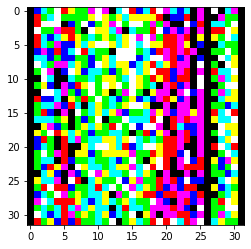

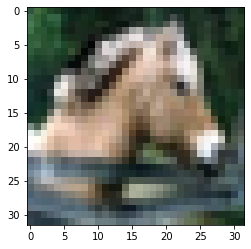

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


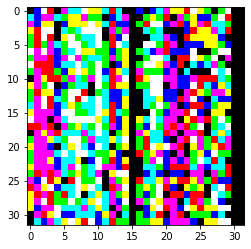

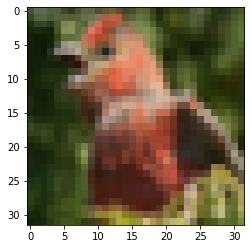

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


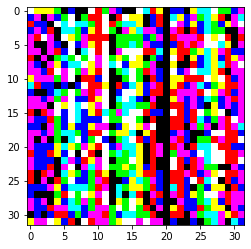

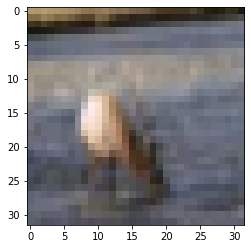

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


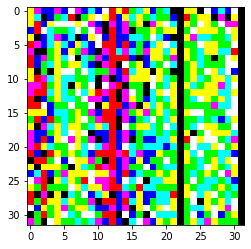

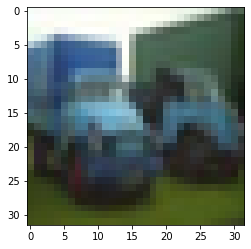

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


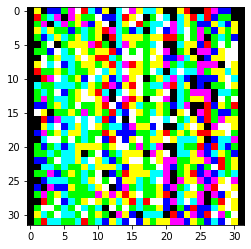

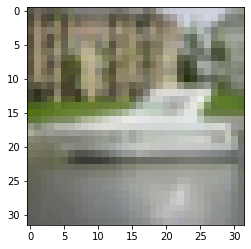

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


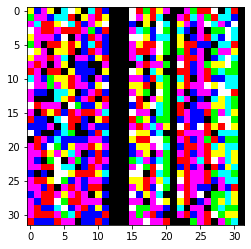

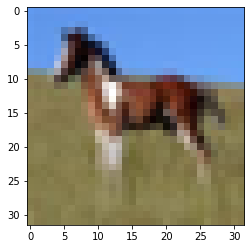

In [19]:
saliency(img=data, steps=100)

## 4.2 Activation Maximization

In [23]:
def activation(img, steps):
  step_size = .005
  opt = tf.optimizers.Adam()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True , name='loss')
  train_acc_metric = tf.metrics.SparseCategoricalAccuracy(name ='acc')
  train_steps = steps
  for step,(img_batch,y) in enumerate(data):
    if step > 5:
      break
    original_img = img_batch
    for step in range(train_steps):
      with tf.GradientTape() as tape:
        tape.watch(img_batch)
        loss = calc_loss(img_batch, model)
      grads = tape.gradient(loss, img_batch)
      grads = tf.math.sign(grads)
      grads /= tf.math.reduce_std(grads) + 1e-8
      img_batch = img_batch +grads * step_size
      img_batch = img_batch +grads * step_size
      img_batch = tf.clip_by_value(img_batch,0,1)

    plt.imshow(grads[0])
    plt.show()

    plt.imshow(original_img[0])
    plt.show()

    plt.imshow(img_batch[0])
    plt.show()

  return 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


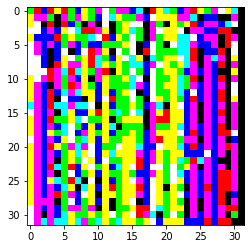

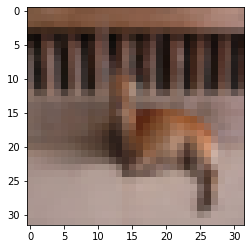

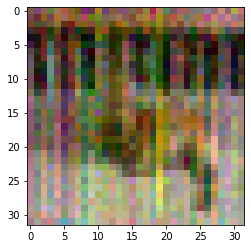

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


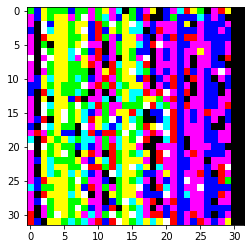

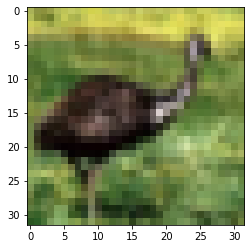

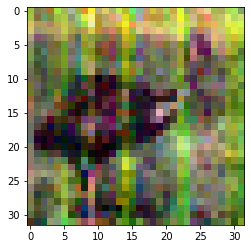

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


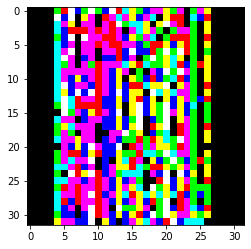

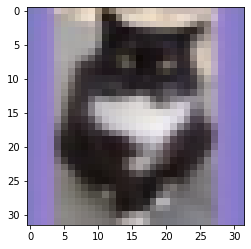

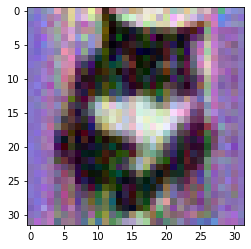

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


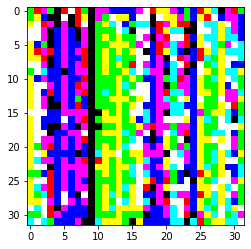

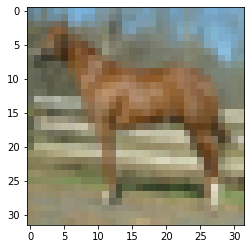

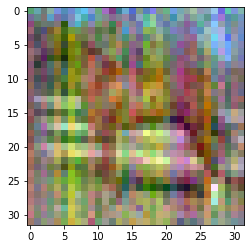

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


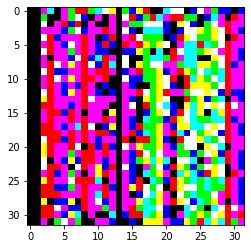

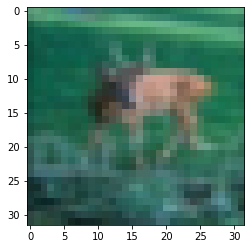

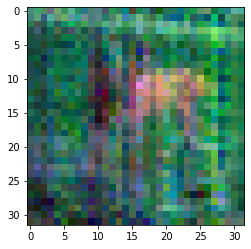

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


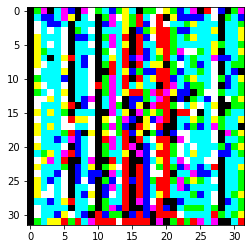

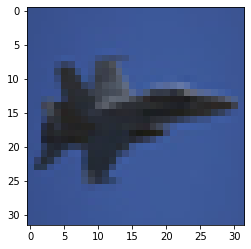

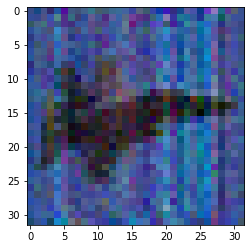

In [24]:
activation(img=data, steps=100)

# Observation
<br>
4.1 - 
Do the saliency maps seem to make sense? How would you interpret them?
<br>
Answer : 
Understanding from the saliency map is very difficult
<br><br>
4.2 - 
<br>
Does the resulting input look natural?
<br>
Answer: The superimposed image almost looks similar to the original one
<br>
<br>
How does the inputs change when applying many steps of optimization?
<br>
Answer: Increasing the steps makes the image more sharper.
<br>
<br>
How do the optimal inputs differ when initializing the optimization with random 
noise instead of real examples?
<br>
Answer : If we initialize the image with noise then image looks unrealistic.